In [1]:
%matplotlib notebook

# Dataset maps

This notebook demonstrates the usage of "data maps" as shown in the paper [Dataset Cartography: Mapping and Diagnosing Datasets with Training Dynamics](https://arxiv.org/pdf/2009.10795) on the QNLI dataset, using the DistilBERT model.

To run this notebook, make sure you have installed the following libraries:
 - `tensorflow`
 - `tensorflow-datasets`
 - `transformers`
 - `tavolo`
 - `matplotlib`
 - `seaborn`
 - `gensim`
 - `scikit-learn`

In [2]:
import re
import tempfile
from typing import Iterable, List, Optional, Tuple

import gensim.downloader as api
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow as tf
import tavolo as tvl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from transformers import DistilBertTokenizer, RobertaTokenizerFast, TFRobertaForSequenceClassification, \
    TFDistilBertForSequenceClassification, glue_convert_examples_to_features

In [3]:
# Set plot style
sns.set_style('whitegrid')
sns.set_palette('Set2')

## Helper functions

In [4]:
def get_samples_by_index(dataset: tf.data.Dataset, indices: List[int]) -> List[dict]:
    """
    Get samples by their index

    :param dataset:
    :param indices:
    :return:
    """

    # Convert to tensor
    indices_ = tf.convert_to_tensor(indices, dtype=tf.int32)

    samples = list()
    for sample in train_unshuffled.filter(lambda x: tf.reduce_any(tf.equal(x['idx'], indices_))).as_numpy_iterator():
        sample['question'], sample['sentence'] = sample['question'].decode(), sample['sentence'].decode()
        samples.append(sample)

        # Early stop
        if len(samples) == len(indices):
            break

    return samples


def pretty_print_samples(samples: List[dict], title: Optional[str]):
    """
    Print samples as Markdown

    :param samples: Samples to print
    :param title: Title
    :return:
    """

    # Convert samples to markdown
    samples_as_markdown = list()
    for sample in samples:
        samples_as_markdown.append(f"""
 - **Question**: {sample['question']}
 
   **Sentence**: {sample['sentence']}
   
   **Label**: {'True' if sample['label'] == 0 else 'False'}
   
   
""")
    samples_as_markdown = "\n".join(samples_as_markdown)

    markdown_output = f"""
### {title}
{samples_as_markdown}
"""

    display(Markdown(markdown_output))

def extract_by_training_dynamics(datamap: np.ndarray,
                                 n_ambiguous: int = 0,
                                 n_easy2learn: int = 0,
                                 n_hard2learn: int = 0) -> Tuple[list, list, list]:
    """
    Extract indices of different types of samples

    :param datamap: Datamap
    :param n_ambiguous: Number of ambiguous samples to extract
    :param n_easy2learn: Number of easy-to-learn samples to extract
    :param n_hard2learn: Number of hard-to-learn samples to extract
    :return: Three lists of ambiguous, easy-to-learn and hard-to-learn indices
    """

    kdt = KDTree(datamap, metric='euclidean')
    ambiguous = list()
    easy2learn = list()
    hard2learn = list()

    if n_easy2learn:
        _, easy2learn = kdt.query([[0, 1]],
                                  k=n_easy2learn)

    if n_ambiguous:
        _, ambiguous = kdt.query([[1, 0.5]],
                                 k=n_ambiguous)

    if n_hard2learn:
        _, hard2learn = kdt.query([[0, 0]],
                                  k=n_hard2learn)

    return list(ambiguous[0]), list(easy2learn[0]), list(hard2learn[0])

## Load Datasets

In [5]:
# Load datasets
train, info = tfds.load('glue/qnli', split='train', shuffle_files=True, with_info=True)
train_unshuffled = tfds.load('glue/qnli', split='train', shuffle_files=False)
validation_ = tfds.load('glue/qnli', split='validation', shuffle_files=True)
validation = validation_.shard(2, index=0)  # Split validation into test and validation
test = validation_.shard(2, index=1)

# Prepare datasets for Huggingface's transformers
bert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
roberta_tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

bert_train = glue_convert_examples_to_features(train, bert_tokenizer, max_length=128, task='qnli')
bert_train_unshuffled = glue_convert_examples_to_features(train_unshuffled, bert_tokenizer, max_length=128, task='qnli')
bert_validation = glue_convert_examples_to_features(validation, bert_tokenizer, max_length=128, task='qnli')
roberta_train = glue_convert_examples_to_features(train, roberta_tokenizer, max_length=128, task='qnli')
roberta_train_unshuffled = glue_convert_examples_to_features(train_unshuffled, roberta_tokenizer, max_length=128, task='qnli')
roberta_validation = glue_convert_examples_to_features(validation, roberta_tokenizer, max_length=128, task='qnli')
bert_validation = bert_validation.batch(128).prefetch(1)
bert_train = bert_train.shuffle(1000).repeat().batch(32).prefetch(1)
roberta_validation = roberta_validation.batch(128).prefetch(1)
roberta_train = roberta_train.shuffle(1000).repeat().batch(32).prefetch(1)


# Prepare dataset for Siamese DSN
wv = api.load('word2vec-google-news-300')

def text_generator():
    for sample in train_unshuffled.as_numpy_iterator():
        question = sample['question'].decode()
        sentence = sample['sentence'].decode()
        
        question = re.sub('\d', '#', question)
        sentence = re.sub('\d', '#', sentence)
        
        yield question
        yield sentence

vectorizer = tf.keras.layers.TextVectorization()
vectorizer.adapt(tf.data.Dataset.from_generator(
                 text_generator,
                 output_signature=tf.TensorSpec(shape=(), dtype=tf.string)).batch(128))

sdsn_train = train.shuffle(1000).repeat().batch(64).map(lambda x: ({'question': vectorizer(tf.strings.regex_replace(x['question'], '\d', '#')),
                                                                   'sentence': vectorizer(tf.strings.regex_replace(x['sentence'], '\d', '#'))}, x['label'])).prefetch(1)
sdsn_validation = validation.batch(64).map(lambda x: ({'question': vectorizer(tf.strings.regex_replace(x['question'], '\d', '#')),
                                                       'sentence': vectorizer(tf.strings.regex_replace(x['sentence'], '\d', '#'))}, x['label'])).prefetch(1)
sdsn_train_unshuffled = train_unshuffled.batch(256).map(lambda x: ({'question': vectorizer(tf.strings.regex_replace(x['question'], '\d', '#')),
                                                        'sentence': vectorizer(tf.strings.regex_replace(x['sentence'], '\d', '#'))}, x['label'])).prefetch(1)


# Test sets
bert_test = glue_convert_examples_to_features(test, bert_tokenizer, max_length=128, task='qnli')
bert_test = bert_test.batch(128).prefetch(1)
roberta_test = glue_convert_examples_to_features(test, roberta_tokenizer, max_length=128, task='qnli')
roberta_test = roberta_test.batch(128).prefetch(1)
sdsn_test = test.batch(256).map(lambda x: ({'question': vectorizer(tf.strings.regex_replace(x['question'], '\d', '#')),
                                            'sentence': vectorizer(tf.strings.regex_replace(x['sentence'], '\d', '#'))}, x['label'])).prefetch(1)

INFO:absl:Load dataset info from /root/tensorflow_datasets/glue/qnli/2.0.0
INFO:absl:Reusing dataset glue (/root/tensorflow_datasets/glue/qnli/2.0.0)
INFO:absl:Constructing tf.data.Dataset glue for split train, from /root/tensorflow_datasets/glue/qnli/2.0.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/glue/qnli/2.0.0
INFO:absl:Reusing dataset glue (/root/tensorflow_datasets/glue/qnli/2.0.0)
INFO:absl:Constructing tf.data.Dataset glue for split train, from /root/tensorflow_datasets/glue/qnli/2.0.0
INFO:absl:Load dataset info from /root/tensorflow_datasets/glue/qnli/2.0.0
INFO:absl:Reusing dataset glue (/root/tensorflow_datasets/glue/qnli/2.0.0)
INFO:absl:Constructing tf.data.Dataset glue for split validation, from /root/tensorflow_datasets/glue/qnli/2.0.0


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.6/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
/usr/local/lib/python3.6/dist-packages/transformers/data/processors/glue.py:475: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'long

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

[--------------------------------------------------] 1.4% 23.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==------------------------------------------------] 4.4% 73.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====----------------------------------------------] 8.7% 145.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=====---------------------------------------------] 11.6% 193.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======-------------------------------------------] 14.6% 242.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========------------------------------------------] 17.6% 293.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========----------------------------------------] 20.7% 343.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========---------------------------------------] 23.7% 393.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============-------------------------------------] 26.7% 444.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============------------------------------------] 29.6% 492.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[================----------------------------------] 32.5% 541.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================---------------------------------] 35.4% 588.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================-------------------------------] 38.3% 636.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================------------------------------] 41.2% 685.3/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[======================----------------------------] 45.7% 759.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[========================--------------------------] 48.6% 807.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==========================------------------------] 53.8% 893.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=============================---------------------] 58.2% 967.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================-------------------] 62.3% 1036.6/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================-----------------] 66.7% 1108.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===================================---------------] 70.6% 1174.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================================--------------] 73.9% 1228.4/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=======================================-----------] 78.4% 1303.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=========================================---------] 82.1% 1365.0/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===========================================-------] 86.8% 1443.5/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[============================================------] 89.7% 1492.2/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[==============================================----] 92.7% 1541.7/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[===============================================---] 95.7% 1590.9/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[=================================================-] 98.6% 1639.8/1662.8MB downloaded

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

/usr/local/lib/python3.6/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
/usr/local/lib/python3.6/dist-packages/transformers/data/processors/glue.py:475: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at

In [6]:
# Dataset checkpoints
bert_best_weights_path = tempfile.NamedTemporaryFile()
roberta_best_weights_path = tempfile.NamedTemporaryFile()
sdsn_best_weights_path = tempfile.NamedTemporaryFile()

## Dataset info

In [7]:
print(info)

tfds.core.DatasetInfo(
    name='glue',
    full_name='glue/qnli/2.0.0',
    description="""
    GLUE, the General Language Understanding Evaluation benchmark
    (https://gluebenchmark.com/) is a collection of resources for training,
    evaluating, and analyzing natural language understanding systems.
    """,
    config_description="""
    The Stanford Question Answering Dataset is a question-answering
    dataset consisting of question-paragraph pairs, where one of the sentences in the paragraph (drawn
    from Wikipedia) contains the answer to the corresponding question (written by an annotator). We
    convert the task into sentence pair classification by forming a pair between each question and each
    sentence in the corresponding context, and filtering out pairs with low lexical overlap between the
    question and the context sentence. The task is to determine whether the context sentence contains
    the answer to the question. This modified version of the original task rem

_Notice_: When the label is 0, it means the sentence (answer) does match the question. **0 = right, 1 = wrong.**

# Bert

## Load model

In [8]:
bert = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-cased')
bert_init_weights_path = tempfile.NamedTemporaryFile()
bert.save_weights(bert_init_weights_path.name)

Downloading:   0%|          | 0.00/338M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use it fo

## Train model

In [9]:
# Compile model
bert_dataset_map = tvl.learning.DataMapCallback(bert_train_unshuffled.batch(128), 
                                                outputs_to_probabilities=lambda x: tf.nn.softmax(x[0]), # Model outputs a tuple, where the logits are at the first index
                                                sparse_labels=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
callbacks = [bert_dataset_map, 
             tf.keras.callbacks.EarlyStopping(patience=5),
             tf.keras.callbacks.ModelCheckpoint(bert_best_weights_path.name, save_best_only=True, save_weights_only=True)]

bert.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [10]:
# Fit
bert.fit(bert_train, epochs=100, validation_data=bert_validation, steps_per_epoch=150, callbacks=callbacks)

Epoch 1/100
  6/150 [>.............................] - ETA: 15s - loss: 0.6986 - accuracy: 0.5208WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0459s vs `on_train_batch_end` time: 0.0493s). Check your callbacks.


150/150 [==============================] - 25s 126ms/step - loss: 0.6218 - accuracy: 0.6377 - val_loss: 0.4909 - val_accuracy: 0.7862
Epoch 2/100
150/150 [==============================] - 18s 122ms/step - loss: 0.5016 - accuracy: 0.7642 - val_loss: 0.4335 - val_accuracy: 0.8126
Epoch 3/100
150/150 [==============================] - 18s 121ms/step - loss: 0.4775 - accuracy: 0.7804 - val_loss: 0.4173 - val_accuracy: 0.8254
Epoch 4/100
150/150 [==============================] - 18s 121ms/step - loss: 0.4533 - accuracy: 0.7981 - val_loss: 0.4427 - val_accuracy: 0.7837
Epoch 5/100
150/150 [==============================] - 18s 121ms/step - loss: 0.4406 - accuracy: 0.8031 - val_loss: 0.3885 - val_accuracy: 0.8225
Epoch 6/100
150/150 [==============================] - 18s 121ms/step - loss: 0.4319 - accuracy: 0.8094 - val_loss: 0.3895 - val_accuracy: 0.8327
Epoch 7/100
150/150 [==============================] - 18s 121ms/step - loss: 0.4251 - accuracy: 0.8188 - val_loss: 0.3917 - val_accurac

# Roberta

## Load model

In [11]:
roberta = TFRobertaForSequenceClassification.from_pretrained('distilroberta-base')
roberta_init_weights_path = tempfile.NamedTemporaryFile()
roberta.save_weights(roberta_init_weights_path.name)

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/465M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Train model

In [12]:
# Compile model
roberta_dataset_map = tvl.learning.DataMapCallback(roberta_train_unshuffled.batch(128), 
                                                   outputs_to_probabilities=lambda x: tf.nn.softmax(x[0]), # Model outputs a tuple, where the logits are at the first index
                                                   sparse_labels=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
callbacks = [roberta_dataset_map, 
             tf.keras.callbacks.EarlyStopping(patience=5),
             tf.keras.callbacks.ModelCheckpoint(roberta_best_weights_path.name, save_best_only=True, save_weights_only=True)]

roberta.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [13]:
# Fit
roberta.fit(roberta_train, epochs=100, validation_data=roberta_validation, steps_per_epoch=150, callbacks=callbacks)

Epoch 1/100
  6/150 [>.............................] - ETA: 15s - loss: 0.6936 - accuracy: 0.4688WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0474s vs `on_train_batch_end` time: 0.0620s). Check your callbacks.


150/150 [==============================] - 25s 131ms/step - loss: 0.5724 - accuracy: 0.6935 - val_loss: 0.4443 - val_accuracy: 0.8097
Epoch 2/100
150/150 [==============================] - 19s 127ms/step - loss: 0.4605 - accuracy: 0.7931 - val_loss: 0.3759 - val_accuracy: 0.8375
Epoch 3/100
150/150 [==============================] - 19s 127ms/step - loss: 0.4406 - accuracy: 0.8048 - val_loss: 0.3598 - val_accuracy: 0.8492
Epoch 4/100
150/150 [==============================] - 19s 127ms/step - loss: 0.4025 - accuracy: 0.8258 - val_loss: 0.3734 - val_accuracy: 0.8422
Epoch 5/100
150/150 [==============================] - 19s 126ms/step - loss: 0.4207 - accuracy: 0.8115 - val_loss: 0.3537 - val_accuracy: 0.8411
Epoch 6/100
150/150 [==============================] - 19s 127ms/step - loss: 0.4053 - accuracy: 0.8231 - val_loss: 0.3391 - val_accuracy: 0.8635
Epoch 7/100
150/150 [==============================] - 19s 127ms/step - loss: 0.3873 - accuracy: 0.8298 - val_loss: 0.3103 - val_accurac

# Siamese DSN

## Train model

In [14]:
# Create embedding matrix
embedding_matrix = np.zeros(shape=(vectorizer.vocabulary_size(), wv.vector_size))

oovs = set()  # Count out of vocabulary words
for i, word in enumerate(vectorizer.get_vocabulary()):
    try:
        embedding_matrix[i, :] = wv[word]
    except KeyError:
        oovs.add(word)

In [15]:
# Model architecture
class SiameseDSN(tf.keras.Model):
    """
    Siamese deep sum network
    """

    def __init__(self, embedding_matrix: np.ndarray):
        super().__init__()

        # Embedding matrix
        self.embedding_matrix = tf.keras.layers.Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
            trainable=False,
            mask_zero=True)

        # Feed forward layers
        self.hidden1 = tf.keras.layers.Dense(units=128,
                                             kernel_regularizer='l2',
                                             activation='relu',
                                             name='hidden1')
        self.hidden2 = tf.keras.layers.Dense(units=64,
                                             kernel_regularizer='l2',
                                             activation='relu',
                                             name='hidden2')

    @tf.function
    def exp_neg_manhattan_distance(self, left, right):
        """
        Distance metric from the MaLSTM paper
        """
        return tf.math.exp(-tf.reduce_sum(tf.math.abs(left - right), axis=1, keepdims=True))  # shape=(batch_size, 1)

    @tf.function
    def as_class_probability(self, out):
        """
        Convert a single probability output to probability per class
        """

        # Interleave ones and zeros
        ones = tf.ones_like(out)
        zeros = tf.zeros_like(out)
        interleaved = tf.reshape(
            tf.concat([ones[..., tf.newaxis], zeros[..., tf.newaxis]], axis=-1),
            [tf.shape(ones)[0], -1])  # shape=(batch_size, 2)

        # Tile
        out_tiled = tf.tile(out, [1, 2])  # shape=(batch_size, 2)

        # As probabilities per class
        class_probabilities = tf.abs(interleaved - out_tiled)

        return class_probabilities

    def call(self, inputs):
        # Unpack
        question, sentence = inputs['question'], inputs['sentence']  # shape=(batch_size, sequence_length)

        # Embed
        question_mask = self.embedding_matrix.compute_mask(question)  # shape=(batch_size, seq_length)
        question = self.embedding_matrix(question)  # shape=(batch_size, seq_length, emb_dim)
        sentence_mask = self.embedding_matrix.compute_mask(sentence)  # shape=(batch_size, seq_length)
        sentence = self.embedding_matrix(sentence)  # shape=(batch_size, seq_length, emb_dim)

        # Sum along embedding dim
        question = tf.reduce_sum(question, axis=1)  # shape=(batch_size, emb_dim)
        sentence = tf.reduce_sum(sentence, axis=1)  # shape=(batch_size, emb_dim)

        # Feed forward
        question = self.hidden2(self.hidden1(question))  # shape=(batch_size, hidden2_dim)
        sentence = self.hidden2(self.hidden1(sentence))  # shape=(batch_size, hidden2_dim)
        
        # Calculate distance
        distance = self.exp_neg_manhattan_distance(question, sentence)  # shape=(batch_size, 1)

        # Convert to class probabilities
        return self.as_class_probability(distance)

In [16]:
sdsn = SiameseDSN(embedding_matrix=embedding_matrix)
sdsn.predict(next(iter(sdsn_train))[0])  # Workaround to initial weights
sdsn_init_weights_path = tempfile.NamedTemporaryFile()
sdsn.save_weights(sdsn_init_weights_path.name)

In [17]:
# Compile model
sdsn_dataset_map = tvl.learning.DataMapCallback(sdsn_train_unshuffled,
                                                sparse_labels=True)
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
callbacks = [sdsn_dataset_map, 
             tf.keras.callbacks.EarlyStopping(patience=5),
             tf.keras.callbacks.ModelCheckpoint(sdsn_best_weights_path.name, save_best_only=True, save_weights_only=True)]

sdsn.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [18]:
sdsn.fit(sdsn_train, epochs=100, validation_data=sdsn_validation, steps_per_epoch=150, callbacks=callbacks)

Epoch 1/100
150/150 [==============================] - 1s 3ms/step - loss: 3.3443 - accuracy: 0.4945 - val_loss: 3.2635 - val_accuracy: 0.4850
Epoch 2/100
150/150 [==============================] - 0s 2ms/step - loss: 2.6991 - accuracy: 0.4842 - val_loss: 2.3056 - val_accuracy: 0.4989
Epoch 3/100
150/150 [==============================] - 0s 2ms/step - loss: 2.3104 - accuracy: 0.4879 - val_loss: 2.1671 - val_accuracy: 0.5018
Epoch 4/100
150/150 [==============================] - 0s 2ms/step - loss: 2.2096 - accuracy: 0.4957 - val_loss: 3.2306 - val_accuracy: 0.4916
Epoch 5/100
150/150 [==============================] - 0s 2ms/step - loss: 2.1700 - accuracy: 0.5033 - val_loss: 2.2072 - val_accuracy: 0.4945
Epoch 6/100
150/150 [==============================] - 0s 2ms/step - loss: 1.9375 - accuracy: 0.4973 - val_loss: 1.8779 - val_accuracy: 0.5139
Epoch 7/100
150/150 [==============================] - 0s 2ms/step - loss: 1.8279 - accuracy: 0.5118 - val_loss: 1.8234 - val_accuracy: 0.5227

Epoch 58/100
150/150 [==============================] - 0s 2ms/step - loss: 0.7504 - accuracy: 0.5786 - val_loss: 0.7565 - val_accuracy: 0.5736
Epoch 59/100
150/150 [==============================] - 0s 2ms/step - loss: 0.7445 - accuracy: 0.5715 - val_loss: 0.7395 - val_accuracy: 0.5802
Epoch 60/100
150/150 [==============================] - 0s 2ms/step - loss: 0.7396 - accuracy: 0.5756 - val_loss: 0.7353 - val_accuracy: 0.5933
Epoch 61/100
150/150 [==============================] - 0s 2ms/step - loss: 0.7373 - accuracy: 0.5699 - val_loss: 0.7298 - val_accuracy: 0.5882
Epoch 62/100
150/150 [==============================] - 0s 2ms/step - loss: 0.7304 - accuracy: 0.5745 - val_loss: 0.7261 - val_accuracy: 0.5827
Epoch 63/100
150/150 [==============================] - 0s 2ms/step - loss: 0.7295 - accuracy: 0.5702 - val_loss: 0.7282 - val_accuracy: 0.5787
Epoch 64/100
150/150 [==============================] - 0s 2ms/step - loss: 0.7242 - accuracy: 0.5715 - val_loss: 0.7244 - val_accuracy:

## 100% Train results

In [19]:
bert.load_weights(bert_best_weights_path.name)
roberta.load_weights(roberta_best_weights_path.name)
sdsn.load_weights(sdsn_best_weights_path.name)

In [20]:
# Evaluate performance on test set
results = pd.DataFrame(index=['100% Train'],
                       columns=['SDSN', 'DistilRoBERTA', 'DistilBERT'],
                       data=[[sdsn.evaluate(sdsn_test)[1]*100, roberta.evaluate(roberta_test)[1]*100, bert.evaluate(bert_test)[1]*100]])

results

22/22 [==============================] - 3s 113ms/step - loss: 0.3264 - accuracy: 0.8638


,SDSN,DistilRoBERTA,DistilBERT
100% Train,58.916146,89.051628,86.378616


## Plot Data Maps

By now we have in the `*_dataset_map` all the information we need to plot the data map for the QNLI training set, for all models

### DistilBert scatter plot

<IPython.core.display.Javascript object>


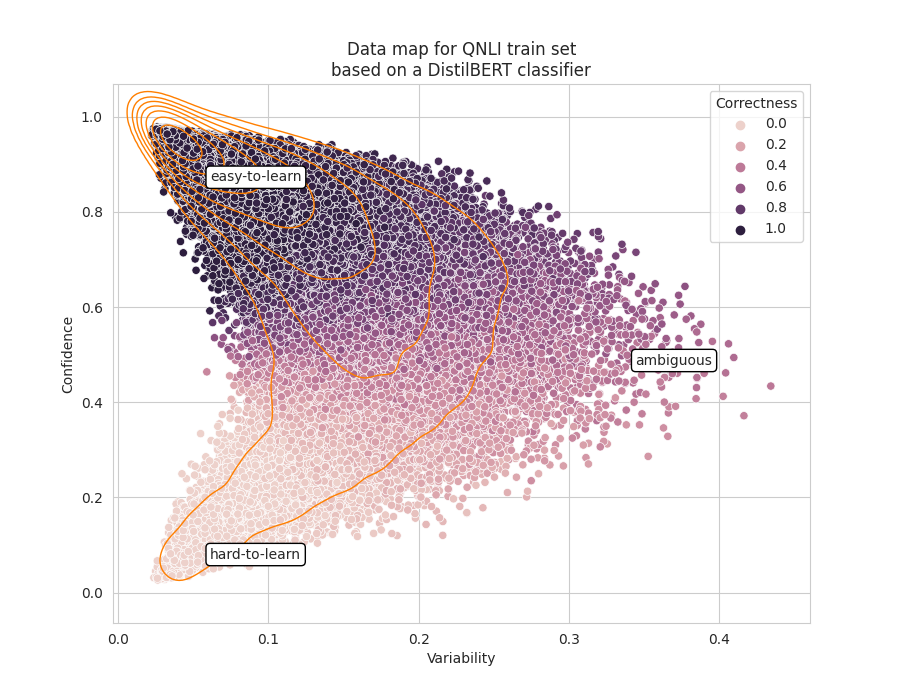

In [21]:
# Plot
_, ax = plt.subplots(figsize=(9, 7))


sns.scatterplot(x=bert_dataset_map.variability, y=bert_dataset_map.confidence, hue=bert_dataset_map.correctness, ax=ax)
sns.kdeplot(x=bert_dataset_map.variability, y=bert_dataset_map.confidence, 
            levels=8, color=sns.color_palette("Paired")[7], linewidths=1, ax=ax)

ax.set(title='Data map for QNLI train set\nbased on a DistilBERT classifier',
       xlabel='Variability', ylabel='Confidence')

# Annotations
box_style = {'boxstyle': 'round', 'facecolor': 'white', 'ec': 'black'}
ax.text(0.14, 0.84,
        'easy-to-learn',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)
ax.text(0.75, 0.5,
        'ambiguous',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)
ax.text(0.14, 0.14,
        'hard-to-learn',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)

ax.legend(title='Correctness');

### DistilRoberta scatter plot

<IPython.core.display.Javascript object>


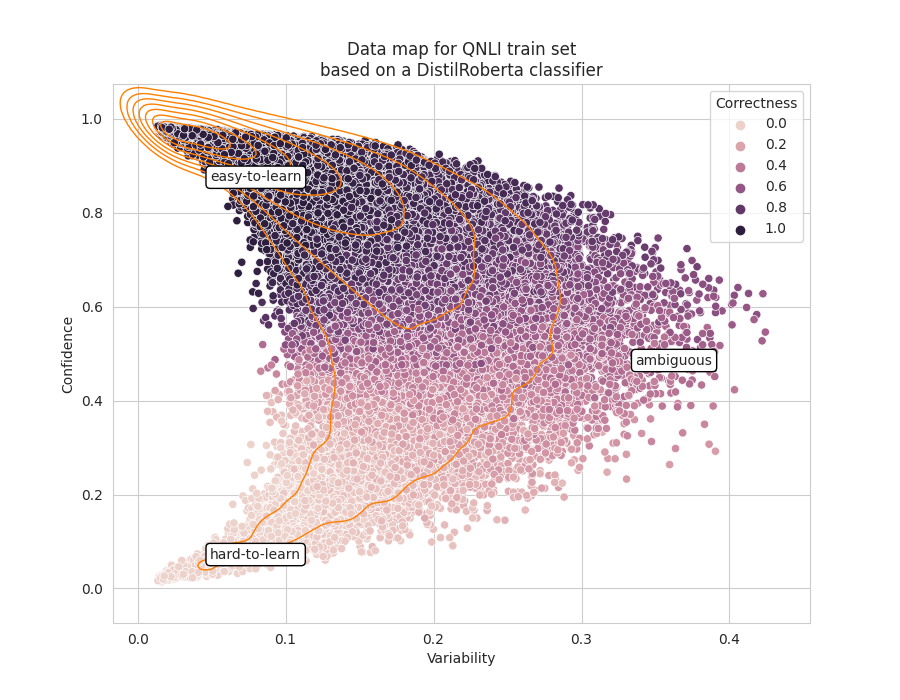

In [22]:
# Plot
_, ax = plt.subplots(figsize=(9, 7))


sns.scatterplot(x=roberta_dataset_map.variability, y=roberta_dataset_map.confidence, hue=roberta_dataset_map.correctness, ax=ax)
sns.kdeplot(x=roberta_dataset_map.variability, y=roberta_dataset_map.confidence, 
            levels=8, color=sns.color_palette("Paired")[7], linewidths=1, ax=ax)

ax.set(title='Data map for QNLI train set\nbased on a DistilRoberta classifier',
       xlabel='Variability', ylabel='Confidence')

# Annotations
box_style = {'boxstyle': 'round', 'facecolor': 'white', 'ec': 'black'}
ax.text(0.14, 0.84,
        'easy-to-learn',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)
ax.text(0.75, 0.5,
        'ambiguous',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)
ax.text(0.14, 0.14,
        'hard-to-learn',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)

ax.legend(title='Correctness');

### SDSN scatter plot 

<IPython.core.display.Javascript object>


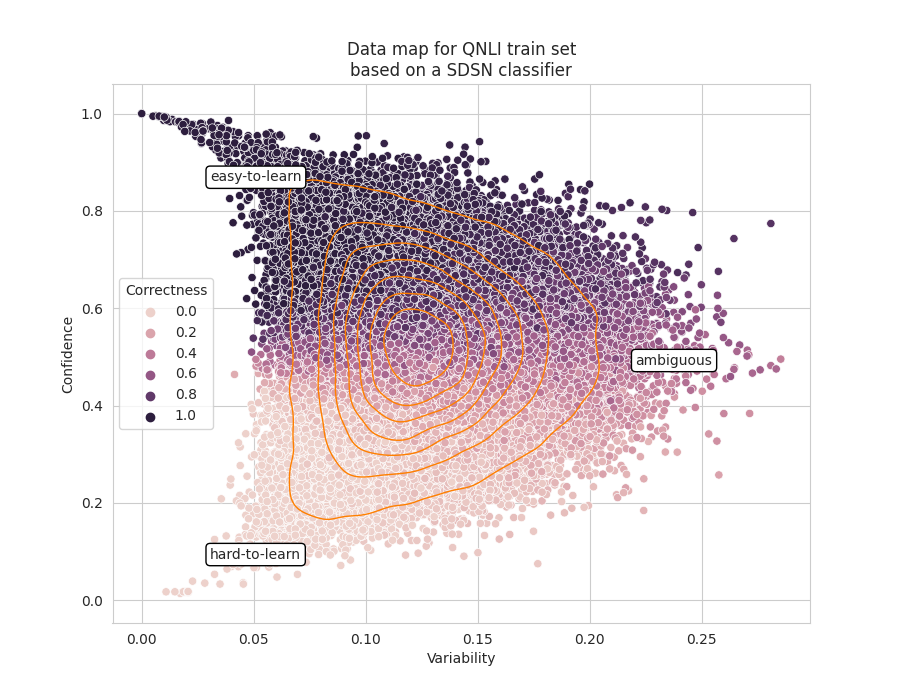

In [23]:
# Plot
_, ax = plt.subplots(figsize=(9, 7))


sns.scatterplot(x=sdsn_dataset_map.variability, y=sdsn_dataset_map.confidence, hue=sdsn_dataset_map.correctness, ax=ax)
sns.kdeplot(x=sdsn_dataset_map.variability, y=sdsn_dataset_map.confidence, 
            levels=8, color=sns.color_palette("Paired")[7], linewidths=1, ax=ax)

ax.set(title='Data map for QNLI train set\nbased on a SDSN classifier',
       xlabel='Variability', ylabel='Confidence')

# Annotations
box_style = {'boxstyle': 'round', 'facecolor': 'white', 'ec': 'black'}
ax.text(0.14, 0.84,
        'easy-to-learn',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)
ax.text(0.75, 0.5,
        'ambiguous',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)
ax.text(0.14, 0.14,
        'hard-to-learn',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)

ax.legend(title='Correctness');

## Training on distilled datasets

In [21]:
# Get the mapping between a sample ID in the dataset, to its index in the order of samples
dataset_id2index = {sample['idx']: i for i, sample in enumerate(train_unshuffled.as_numpy_iterator())}
index2dataset_id = {v: k for k, v in dataset_id2index.items()}

In [22]:
# Calculate agreement on clustering
def get_datamap(data: tvl.learning.DataMapCallback) -> np.ndarray:
    """
    Extract variability and confidence as a matrix of (samples, 2) for clustering
    """

    return np.hstack([np.expand_dims(data.variability, -1), np.expand_dims(data.confidence, -1)])


kmeans = KMeans(n_clusters=3, init=np.array([[1, 0], [1, 0.5], [0, 1]]))

In [23]:
def distill(datamap: np.ndarray, n_ambiguous: int, n_easy2learn: int):
    """
    Get the indices of a distilled dataset
    """

    kdt = KDTree(datamap, metric='euclidean')
    _, ambiguous_idx = kdt.query([[1, 0.5]],
                                 k=n_ambiguous)

    if n_easy2learn:
        _, easy2learn_idx = kdt.query([[0, 1]],
                                      k=n_easy2learn)

        return np.hstack([ambiguous_idx, easy2learn_idx])
    
    return ambiguous_idx

In [24]:
# Get datamaps
bert_datamap = get_datamap(bert_dataset_map)
roberta_datamap = get_datamap(roberta_dataset_map)
sdsn_datamap = get_datamap(sdsn_dataset_map)

In [25]:
n_train_samples = sum(1 for _ in train_unshuffled)
n_ambiguous = int(n_train_samples * 0.12)  # 12 percent
n_easy2learn = int(n_train_samples * 0.03)  # 3 percent

In [26]:
# Distill bert
bert_distilled_idx = distill(bert_datamap, n_ambiguous=n_ambiguous, n_easy2learn=n_easy2learn)
np.random.shuffle(bert_distilled_idx)

# Distill roberta
roberta_distilled_idx = distill(roberta_datamap, n_ambiguous=n_ambiguous, n_easy2learn=n_easy2learn)
np.random.shuffle(roberta_distilled_idx)

# Distill sdsn
sdsn_distilled_idx = distill(sdsn_datamap, n_ambiguous=n_ambiguous, n_easy2learn=n_easy2learn)
np.random.shuffle(sdsn_distilled_idx)

In [27]:
# Build distilled datasets
bert_distilled_train = glue_convert_examples_to_features(train.filter(
    lambda x: tf.reduce_any(tf.equal(x['idx'], tf.convert_to_tensor(bert_distilled_idx, dtype=tf.int32)))), bert_tokenizer, max_length=128, task='qnli')
bert_distilled_train = bert_distilled_train.shuffle(1000).batch(
    32).prefetch(1)

roberta_distilled_train = glue_convert_examples_to_features(train.filter(
    lambda x: tf.reduce_any(tf.equal(x['idx'], tf.convert_to_tensor(roberta_distilled_idx, dtype=tf.int32)))), roberta_tokenizer, max_length=128, task='qnli')
roberta_distilled_train = roberta_distilled_train.shuffle(1000).batch(
    32).prefetch(1)

sdsn_distilled_train = train.filter(
    lambda x: tf.reduce_any(tf.equal(x['idx'], tf.convert_to_tensor(sdsn_distilled_idx, dtype=tf.int32)))).shuffle(1000).batch(
    32).map(lambda x: ({'question': vectorizer(tf.strings.regex_replace(x['question'], '\d', '#')),
                        'sentence': vectorizer(tf.strings.regex_replace(x['sentence'], '\d', '#'))},
                       x['label'])).prefetch(1)

/usr/local/lib/python3.6/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)
/usr/local/lib/python3.6/dist-packages/transformers/data/processors/glue.py:475: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'long

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [28]:
# Load initial weights
bert.load_weights(bert_init_weights_path.name)
roberta.load_weights(roberta_init_weights_path.name)
sdsn.load_weights(sdsn_init_weights_path.name)

# Recompile
bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
roberta.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
sdsn.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [29]:
bert.fit(bert_distilled_train, epochs=100, validation_data=bert_validation, 
         callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
                    tf.keras.callbacks.ModelCheckpoint(bert_best_weights_path.name, save_best_only=True, save_weights_only=True)])

Epoch 1/100
491/491 [==============================] - 58s 110ms/step - loss: 0.5202 - accuracy: 0.7406 - val_loss: 0.3858 - val_accuracy: 0.8291
Epoch 2/100
491/491 [==============================] - 54s 109ms/step - loss: 0.3511 - accuracy: 0.8542 - val_loss: 0.4222 - val_accuracy: 0.8177
Epoch 3/100
491/491 [==============================] - 54s 109ms/step - loss: 0.2087 - accuracy: 0.9208 - val_loss: 0.5123 - val_accuracy: 0.8316
Epoch 4/100
491/491 [==============================] - 54s 109ms/step - loss: 0.1175 - accuracy: 0.9594 - val_loss: 0.6090 - val_accuracy: 0.8177
Epoch 5/100
491/491 [==============================] - 54s 109ms/step - loss: 0.0737 - accuracy: 0.9749 - val_loss: 0.7782 - val_accuracy: 0.8203
Epoch 6/100
491/491 [==============================] - 54s 110ms/step - loss: 0.0566 - accuracy: 0.9810 - val_loss: 0.7199 - val_accuracy: 0.8280


In [30]:
roberta.fit(roberta_distilled_train, epochs=100, validation_data=roberta_validation, 
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
                       tf.keras.callbacks.ModelCheckpoint(roberta_best_weights_path.name, save_best_only=True, save_weights_only=True)])

Epoch 1/100
491/491 [==============================] - 62s 116ms/step - loss: 0.4947 - accuracy: 0.7612 - val_loss: 0.3392 - val_accuracy: 0.8569
Epoch 2/100
491/491 [==============================] - 57s 115ms/step - loss: 0.3447 - accuracy: 0.8553 - val_loss: 0.3292 - val_accuracy: 0.8627
Epoch 3/100
491/491 [==============================] - 57s 115ms/step - loss: 0.2371 - accuracy: 0.9090 - val_loss: 0.3660 - val_accuracy: 0.8635
Epoch 4/100
491/491 [==============================] - 57s 115ms/step - loss: 0.1553 - accuracy: 0.9448 - val_loss: 0.4604 - val_accuracy: 0.8463
Epoch 5/100
491/491 [==============================] - 57s 115ms/step - loss: 0.1071 - accuracy: 0.9612 - val_loss: 0.4500 - val_accuracy: 0.8583
Epoch 6/100
491/491 [==============================] - 57s 115ms/step - loss: 0.0743 - accuracy: 0.9743 - val_loss: 0.5717 - val_accuracy: 0.8547
Epoch 7/100
491/491 [==============================] - 57s 115ms/step - loss: 0.0577 - accuracy: 0.9801 - val_loss: 0.6594 -

In [31]:
sdsn.fit(sdsn_distilled_train, epochs=100, validation_data=sdsn_validation, 
         callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
                    tf.keras.callbacks.ModelCheckpoint(sdsn_best_weights_path.name, save_best_only=True, save_weights_only=True)])

Epoch 1/100
491/491 [==============================] - 3s 5ms/step - loss: 2.7320 - accuracy: 0.4891 - val_loss: 2.0492 - val_accuracy: 0.4989
Epoch 2/100
491/491 [==============================] - 2s 4ms/step - loss: 1.8044 - accuracy: 0.5221 - val_loss: 1.6053 - val_accuracy: 0.5421
Epoch 3/100
491/491 [==============================] - 2s 4ms/step - loss: 1.5144 - accuracy: 0.5333 - val_loss: 1.3774 - val_accuracy: 0.5421
Epoch 4/100
491/491 [==============================] - 2s 5ms/step - loss: 1.3782 - accuracy: 0.5280 - val_loss: 1.2979 - val_accuracy: 0.5362
Epoch 5/100
491/491 [==============================] - 2s 5ms/step - loss: 1.1867 - accuracy: 0.5559 - val_loss: 1.1326 - val_accuracy: 0.5344
Epoch 6/100
491/491 [==============================] - 3s 5ms/step - loss: 1.0668 - accuracy: 0.5628 - val_loss: 1.0282 - val_accuracy: 0.5516
Epoch 7/100
491/491 [==============================] - 3s 5ms/step - loss: 0.9705 - accuracy: 0.5780 - val_loss: 0.9578 - val_accuracy: 0.5542

In [32]:
bert.load_weights(bert_best_weights_path.name)
roberta.load_weights(roberta_best_weights_path.name)
sdsn.load_weights(sdsn_best_weights_path.name)

In [33]:
distilled_results = pd.DataFrame(index=['15% Distilled'], 
                                 columns=['SDSN', 'DistilRoBERTA', 'DistilBERT'],
                                 data=[[sdsn.evaluate(sdsn_test)[1]*100, roberta.evaluate(roberta_test)[1]*100, bert.evaluate(bert_test)[1]*100]])
results = results.append(distilled_results)

22/22 [==============================] - 3s 113ms/step - loss: 0.4153 - accuracy: 0.8242


In [34]:
results

,SDSN,DistilRoBERTA,DistilBERT
100% Train,58.916146,89.051628,86.378616
15% Distilled,57.707798,84.474552,82.424021


## Agreement on clusters

In [38]:
# Bert
bert_clusters = kmeans.fit_predict(bert_datamap)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [39]:
# Roberta
roberta_clusters = kmeans.fit_predict(roberta_datamap)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [40]:
# SDSN
sdsn_clusters = kmeans.fit_predict(sdsn_datamap)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [41]:
# Calculate mutual information
adjusted_mutual_info = np.zeros(shape=(3, 3))
mask = np.zeros_like(adjusted_mutual_info)
mask[np.triu_indices_from(mask)] = True

adjusted_mutual_info[1, 0] = adjusted_mutual_info_score(roberta_clusters, sdsn_clusters)
adjusted_mutual_info[2, 0] = adjusted_mutual_info_score(bert_clusters, sdsn_clusters)
adjusted_mutual_info[2, 1] = adjusted_mutual_info_score(bert_clusters, roberta_clusters)

<IPython.core.display.Javascript object>


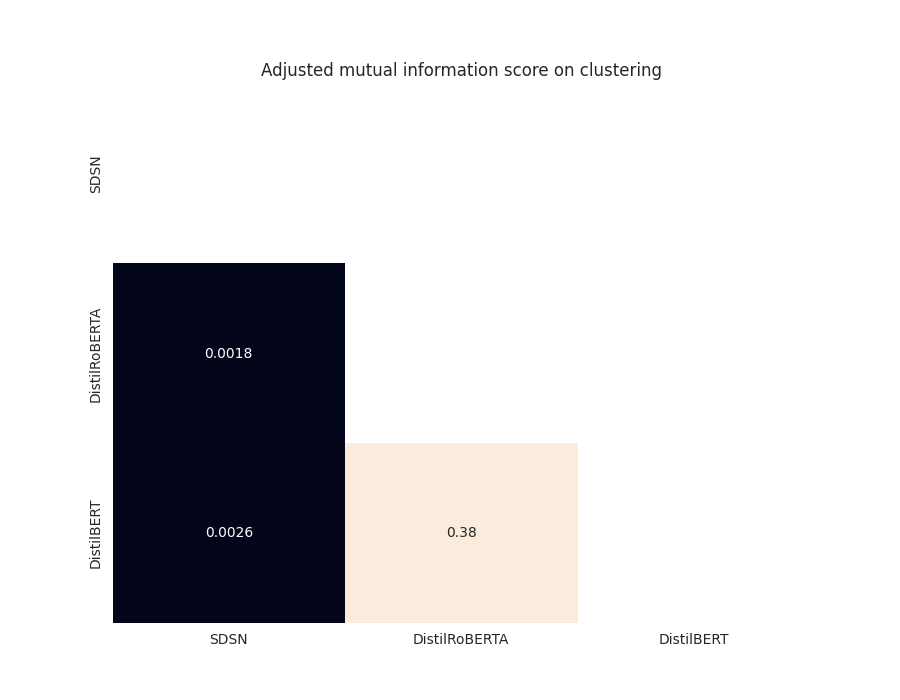

In [42]:
# Plot
_, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(adjusted_mutual_info, annot=True, mask=mask, cbar=False,
            xticklabels=['SDSN', 'DistilRoBERTA', 'DistilBERT'], yticklabels=['SDSN', 'DistilRoBERTA', 'DistilBERT'])
ax.set(title='Adjusted mutual information score on clustering');

In [54]:
average_location = np.mean(np.stack([bert_datamap, roberta_datamap, sdsn_datamap], axis=-1), axis=-1)

# Calculate average distance from average location
average_distance = np.mean(np.stack([
    np.linalg.norm(bert_datamap - average_location, axis=-1),
    np.linalg.norm(roberta_datamap - average_location, axis=-1),
    np.linalg.norm(sdsn_datamap - average_location, axis=-1)
], axis=-1), axis=-1)

# Sort for visibility of high distance points
sorted_idx = np.argsort(average_distance)

<IPython.core.display.Javascript object>


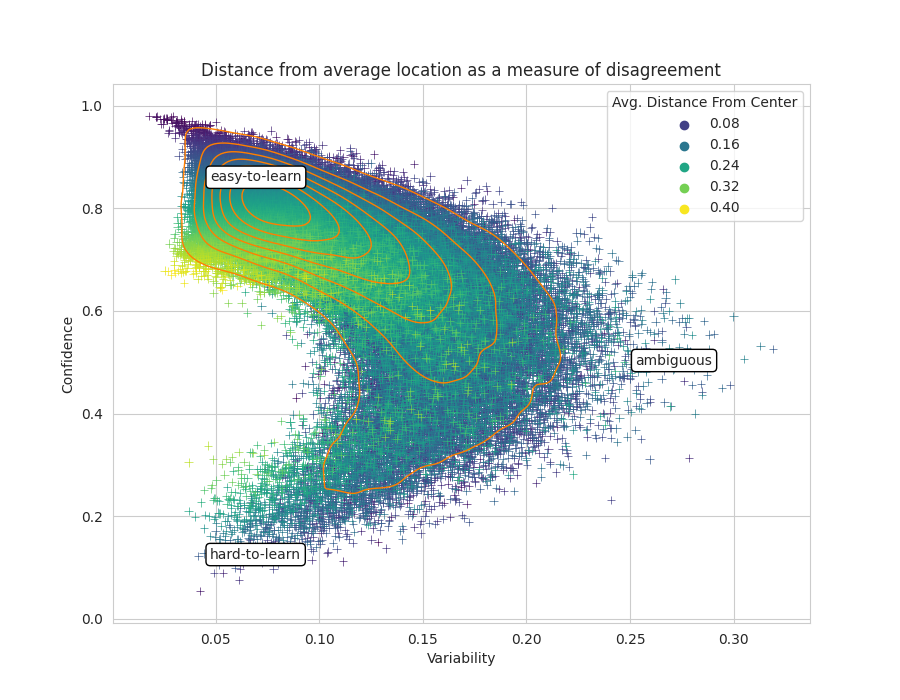

In [56]:
# Plot
_, ax = plt.subplots(figsize=(9, 7))


sns.scatterplot(x=average_location[sorted_idx, 0], 
                y=average_location[sorted_idx, 1], 
                hue=average_distance[sorted_idx], 
                ax=ax, marker="+",
                palette=sns.color_palette("viridis", as_cmap=True))
sns.kdeplot(x=average_location[:, 0], y=average_location[:, 1], 
            levels=8, color=sns.color_palette("Paired")[7], linewidths=1, ax=ax)

ax.set(title='Distance from average location as a measure of disagreement',
       xlabel='Variability', ylabel='Confidence')

# Annotations
box_style = {'boxstyle': 'round', 'facecolor': 'white', 'ec': 'black'}
ax.text(0.14, 0.84,
        'easy-to-learn',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)
ax.text(0.75, 0.5,
        'ambiguous',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)
ax.text(0.14, 0.14,
        'hard-to-learn',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)

ax.legend(title='Avg. Distance From Center');

In [57]:
# Do the same only for bert + roberta
average_location = np.mean(np.stack([bert_datamap, roberta_datamap], axis=-1), axis=-1)

# Calculate average distance from average location
average_distance = np.mean(np.stack([
    np.linalg.norm(bert_datamap - average_location, axis=-1),
    np.linalg.norm(roberta_datamap - average_location, axis=-1)
], axis=-1), axis=-1)

# Sort for visibility of high distance points
sorted_idx = np.argsort(average_distance)

<IPython.core.display.Javascript object>


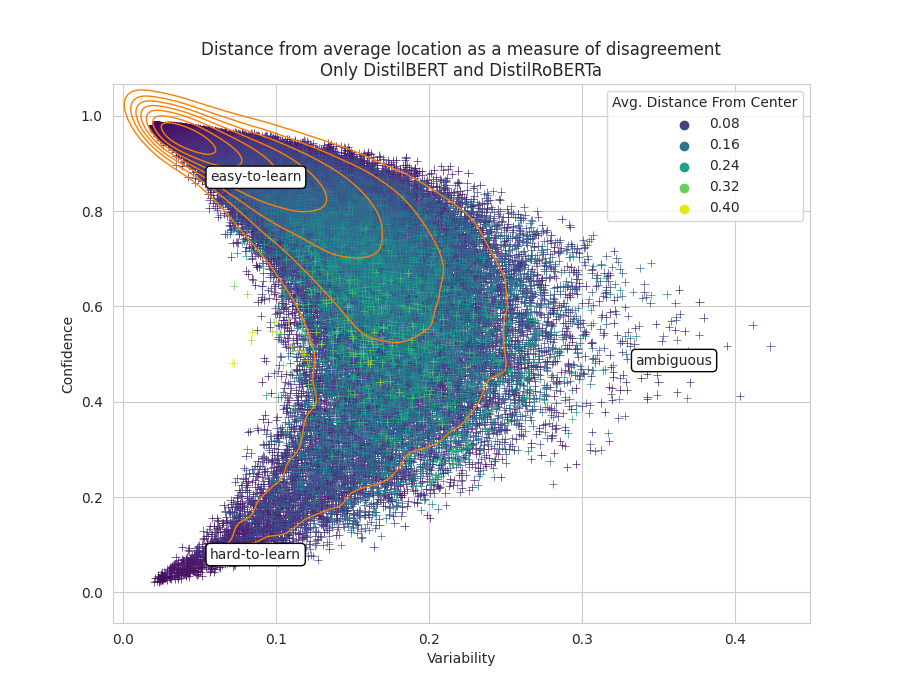

In [58]:
# Plot
_, ax = plt.subplots(figsize=(9, 7))


sns.scatterplot(x=average_location[sorted_idx, 0], 
                y=average_location[sorted_idx, 1], 
                hue=average_distance[sorted_idx], 
                ax=ax, marker="+",
                palette=sns.color_palette("viridis", as_cmap=True))
sns.kdeplot(x=average_location[:, 0], y=average_location[:, 1], 
            levels=8, color=sns.color_palette("Paired")[7], linewidths=1, ax=ax)

ax.set(title='Distance from average location as a measure of disagreement\nOnly DistilBERT and DistilRoBERTa',
       xlabel='Variability', ylabel='Confidence')

# Annotations
box_style = {'boxstyle': 'round', 'facecolor': 'white', 'ec': 'black'}
ax.text(0.14, 0.84,
        'easy-to-learn',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)
ax.text(0.75, 0.5,
        'ambiguous',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)
ax.text(0.14, 0.14,
        'hard-to-learn',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=box_style)

ax.legend(title='Avg. Distance From Center');

# Data sub-problems

## BERT

In [35]:
bert_ambiguous_idx, bert_easy2learn_idx, bert_hard2learn_idx = extract_by_training_dynamics(bert_datamap, 10, 10, 10)

bert_ambiguous_samples = get_samples_by_index(train_unshuffled, bert_ambiguous_idx)
bert_easy2learn_samples = get_samples_by_index(train_unshuffled, bert_easy2learn_idx)
bert_hard2learn_samples = get_samples_by_index(train_unshuffled, bert_hard2learn_idx)

pretty_print_samples(bert_ambiguous_samples, "BERT Ambiguous")
pretty_print_samples(bert_easy2learn_samples, "BERT Easy-to-learn")
pretty_print_samples(bert_hard2learn_samples, "BERT Hard-to-learn")


### BERT Ambiguous

 - **Question**: What was the English title of Le scandale?
 
   **Sentence**: Except for the two first films it produced, Claude Chabrol's Le scandale (English title The Champagne Murders) and Romain Gary's Les oiseaux vont mourir au Pérou (English title Birds in Peru), it was only involved in French or other European co-productions, the most noticeable ones being Louis Malle's Lacombe, Lucien, Bertrand Blier's Les Valseuses (English title Going Places), and Fred Zinnemann's The Day of the Jackal.
   
   **Label**: True
   
   


 - **Question**: All entities, being unable to predict behavior, are because of what?
 
   **Sentence**: Moreover, inability to predict an electron's movement (for instance) is not due to faulty understanding or inadequate technology; rather, the fundamental creativity/freedom of all entities means that there will always remain phenomena that are unpredictable.
   
   **Label**: True
   
   


 - **Question**: Where did Beyoncé perform on January 20, 2009?
 
   **Sentence**: On January 20, 2009, Beyoncé performed James' "
   
   **Label**: False
   
   


 - **Question**: How do dogs establish their territory as far as scent is concerned?
 
   **Sentence**: There are a vast range of commodity forms available to transform a pet dog into an ideal companion.
   
   **Label**: False
   
   


 - **Question**: Who is the founder of Dell?
 
   **Sentence**: Michael Dell, the founder of the company, serves as chairman of the board and chief executive officer.
   
   **Label**: True
   
   


 - **Question**: Which British territory received independence in 1962?
 
   **Sentence**: Most of the UK's Caribbean territories achieved independence after the departure in 1961 and 1962 of Jamaica and Trinidad from the West Indies Federation, established in 1958 in an attempt to unite the British Caribbean colonies under one government, but which collapsed following the loss of its two largest members.
   
   **Label**: True
   
   


 - **Question**: The original Veda of the rishis was altered by a few Brahmins who introduced what?
 
   **Sentence**: He names the Vedic rishis, and declared that the original Veda of the rishis[note 25] was altered by a few Brahmins who introduced animal sacrifices.
   
   **Label**: True
   
   


 - **Question**: What year was Tuscon's largest office building built?
 
   **Sentence**: Tucson's largest office building is 5151 East Broadway in east Tucson, completed in 1975.
   
   **Label**: True
   
   


 - **Question**: What happens as the scope of economically viable applications increases?
 
   **Sentence**: As the cost of renewable power falls, the scope of economically viable applications increases.
   
   **Label**: True
   
   


 - **Question**: In 2006, which Northwestern linebacker became the youngest Division/FBS coach at the time?
 
   **Sentence**: At one time, Northwestern had the longest losing streak in Division I-A, losing 34 consecutive games between 1979 and 1982.
   
   **Label**: False
   
   




### BERT Easy-to-learn

 - **Question**: What were CD-V's video capacities usually used for?
 
   **Sentence**: A CD-V carried up to five minutes of analog LaserDisc-type video content (usually a music video), as well as up to 20 minutes of digital audio CD tracks.
   
   **Label**: True
   
   


 - **Question**: What company manufactured Elixir Sulfanilamide?
 
   **Sentence**: In 1937 over 100 people died after ingesting "Elixir Sulfanilamide" manufactured by S.E. Massengill Company of Tennessee.
   
   **Label**: True
   
   


 - **Question**: What government took over from the Manchu dynasty?
 
   **Sentence**: , also called the Empire of the Great Qing, or the Manchu dynasty, was the last imperial dynasty of China, ruling from 1644 to 1912 with a brief, abortive restoration in 1917.
   
   **Label**: False
   
   


 - **Question**: When did the war in Europe end?
 
   **Sentence**: Many prematurely considered that victory in Europe would come by summer's end—however the Germans did not capitulate for almost a year.
   
   **Label**: False
   
   


 - **Question**: What structure did Jens Galschiøt build to monumentalize the Tianamen Square protests in 1989?
 
   **Sentence**: The Color Orange democracy group, led by Danish sculptor Jens Galschiøt, originally planned to join the Hong Kong Alliance relay and paint the "Pillar of Shame", a structure he built in Hong Kong to commemorate the 1989 Tiananmen Square protests.
   
   **Label**: True
   
   


 - **Question**: How many number one singles did Queen release?
 
   **Sentence**: The band have released a total of eighteen number one albums, eighteen number one singles, and ten number one DVDs worldwide, making them one of the world's best-selling music artists.
   
   **Label**: True
   
   


 - **Question**: Where does the mandolin that Gaetano Vinaccia reside?
 
   **Sentence**: There is confusion currently as to the name of the eldest Vinaccia luthier who first ran the shop.
   
   **Label**: False
   
   


 - **Question**: Is the structure of hardwood simple or complex?
 
   **Sentence**: The structure of hardwoods is more complex.
   
   **Label**: True
   
   


 - **Question**: Avoiding drugs and using condoms are other forms of what?
 
   **Sentence**: There are other forms of prevention such as avoiding the use of illicit drugs, using a condom, and having a healthy lifestyle with a balanced diet and regular exercise.
   
   **Label**: True
   
   


 - **Question**: What can a citizen of Georgia not be compelled to do?
 
   **Sentence**: No person within this state shall, upon any pretense, be deprived of the inestimable privilege of worshipping God in any manner agreeable to his own conscience, nor be compelled to attend any place of worship contrary to his own faith and judgment; nor shall he ever be obliged to pay tithes, taxes, or any other rate, for the building or repairing any place of worship, or for the maintenance of any minister or ministry, contrary to what he believes to be right, or hath voluntarily engaged to do.
   
   **Label**: True
   
   




### BERT Hard-to-learn

 - **Question**: Which is the tallest mountain in Sicily?
 
   **Sentence**: The tallest peak of the range is La Pizzuta, about 1,333 m (4,373 ft.) high.
   
   **Label**: True
   
   


 - **Question**: What threat was John worried about?
 
   **Sentence**: By 1213, though, John was increasingly worried about the threat of French invasion.
   
   **Label**: True
   
   


 - **Question**: What is there little coherent relationships between?
 
   **Sentence**: There is "little coherent relationship between the amount and mix of homosexual and heterosexual behavior in a person's biography and that person's choice to label himself or herself as bisexual, homosexual, or heterosexual".
   
   **Label**: True
   
   


 - **Question**: How much was the signing payment for Diego Maradona?
 
   **Sentence**: In June 1982, Diego Maradona was signed for a world record fee of £5 million from Boca Juniors.
   
   **Label**: True
   
   


 - **Question**: When did the Montevideo Cabildo become a National Heritage Site?
 
   **Sentence**: Built between 1804 and 1869 in Neoclassical style, with a series of Doric and Ionic columns, it became a National Heritage Site in 1975.
   
   **Label**: True
   
   


 - **Question**: How many members compose the legislature?
 
   **Sentence**: At the legislative level, a unicameral Assembleia Nacional Popular (National People's Assembly) is made up of 100 members.
   
   **Label**: True
   
   


 - **Question**: Towards the end of what year did That's Solent begin broadcasting?
 
   **Sentence**: That's Solent is an local television channel that began broadcasting in November 2014, which will be based in and serve Southampton and Portsmouth.
   
   **Label**: True
   
   


 - **Question**: When did Peter Lombard die?
 
   **Sentence**: Scholars such as Peter Abelard (d. 1142) and Peter Lombard (d. 1164) introduced Aristotelian logic into theology.
   
   **Label**: True
   
   


 - **Question**: Which cities are called Stadtstaaten, other than Bremen?
 
   **Sentence**: Since today's Germany was formed from an earlier collection of several states, it has a federal constitution, and the constituent states retain a measure of sovereignty.
   
   **Label**: False
   
   


 - **Question**: What disagreements did the  Luftwaffe staff center around?
 
   **Sentence**: Disputes among the OKL staff revolved more around tactics than strategy.
   
   **Label**: True
   
   



## RoBERTa

In [37]:
roberta_ambiguous_idx, roberta_easy2learn_idx, roberta_hard2learn_idx = extract_by_training_dynamics(roberta_datamap, 10, 10, 10)

roberta_ambiguous_samples = get_samples_by_index(train_unshuffled, roberta_ambiguous_idx)
roberta_easy2learn_samples = get_samples_by_index(train_unshuffled, roberta_easy2learn_idx)
roberta_hard2learn_samples = get_samples_by_index(train_unshuffled, roberta_hard2learn_idx)

pretty_print_samples(roberta_ambiguous_samples, "RoBERTa Ambiguous")
pretty_print_samples(roberta_easy2learn_samples, "RoBERTa Easy-to-learn")
pretty_print_samples(roberta_hard2learn_samples, "RoBERTa Hard-to-learn")


### RoBERTa Ambiguous

 - **Question**: In 1995, who decided to manage the girls singing group?
 
   **Sentence**: They were placed into a group with three other girls as Girl's Tyme, and rapped and danced on the talent show circuit in Houston.
   
   **Label**: False
   
   


 - **Question**: What was the grand total of German casualties and those missing in action?
 
   **Sentence**: A grand total of 20,163 German troops were killed, wounded or missing in action during the August 18 battle.
   
   **Label**: True
   
   


 - **Question**: Where did Libya manufacture mustard gas?
 
   **Sentence**: The period also saw a growth in domestic Islamist opposition, formulated into groups like the Muslim Brotherhood and the Libyan Islamic Fighting Group.
   
   **Label**: False
   
   


 - **Question**: Before 1919 what were the German states called?
 
   **Sentence**: Before this time, the constituent states of the German Empire were called Staaten (States).
   
   **Label**: True
   
   


 - **Question**: How do dogs establish their territory as far as scent is concerned?
 
   **Sentence**: There are a vast range of commodity forms available to transform a pet dog into an ideal companion.
   
   **Label**: False
   
   


 - **Question**: When did Governor Christie say that the state would consider a referendum?
 
   **Sentence**: With casino revenue declining from $5.2 billion in 2006 to $2.9 billion in 2013, the state saw a drop in money from its 8% tax on those earnings, which is used to fund programs for senior citizens and the disabled.
   
   **Label**: False
   
   


 - **Question**: Around what year did the International Gothic style flourish?
 
   **Sentence**: Northern Europe and Spain continued to use Gothic styles, which became increasingly elaborate in the 15th century, until almost the end of the period.
   
   **Label**: False
   
   


 - **Question**: Conversely the scholars who did view the Serbs' acts as constituting genocide, were backed up by what Tribunal?
 
   **Sentence**: The ECHR also noted that in the 21st century "Amongst scholars, the majority have taken the view that ethnic cleansing, in the way in which it was carried out by the Serb forces in Bosnia and Herzegovina in order to expel Muslims and Croats from their homes, did not constitute genocide.
   
   **Label**: False
   
   


 - **Question**: What type of establishment was Wan Mee?
 
   **Sentence**: This success brought an influx of new residents with a population increase within city limits of almost 50,000 between 1990 and 2000, and saw Seattle's real estate become some of the most expensive in the country.
   
   **Label**: False
   
   


 - **Question**: What is the backbone of a DNA double helix made of?
 
   **Sentence**: The two strands in a double helix must therefore be complementary, with their sequence of bases matching such that the adenines of one strand are paired with the thymines of the other strand, and so on.:4.1
   
   **Label**: False
   
   




### RoBERTa Easy-to-learn

 - **Question**: Smyth wrote a tract titled what?
 
   **Sentence**: He was convinced on the basis of his interpretation of Scripture that infants would not be damned should they die in infancy.
   
   **Label**: False
   
   


 - **Question**: What is supposed to be the last resort for police?
 
   **Sentence**: The use of firearms or deadly force is typically a last resort only to be used when necessary to save human life, although some jurisdictions (such as Brazil) allow its use against fleeing felons and escaped convicts.
   
   **Label**: True
   
   


 - **Question**: What year did the Queen and Albert purchase Balmoral Castle?
 
   **Sentence**: She agreed to visit the gardens of the Royal Horticultural Society at Kensington and take a drive through London in an open carriage.
   
   **Label**: False
   
   


 - **Question**: How was the suit settled?
 
   **Sentence**: It was settled out of court by her lawyers in June 2013 who said that they had cancelled because GateFive had lost its financial backers.
   
   **Label**: True
   
   


 - **Question**: What does EAL stand for?
 
   **Sentence**: Many common operating systems meet the EAL4 standard of being "Methodically Designed, Tested and Reviewed", but the formal verification required for the highest levels means that they are uncommon.
   
   **Label**: False
   
   


 - **Question**: Why are long sentences in a modern preamble formatted into multiple paragraphs?
 
   **Sentence**: Modern preambles are sometimes structured as a single very long sentence formatted into multiple paragraphs for readability, in which each of the paragraphs begins with a verb (desiring, recognizing, having, and so on).
   
   **Label**: True
   
   


 - **Question**: Has there been a recent increase or decrease in international students studying in Melbourne?
 
   **Sentence**: Of the top twenty high schools in Australia according to the Better Education ranking, six are located in Melbourne.
   
   **Label**: False
   
   


 - **Question**: What does the Dutch word "kroes" mean in English?
 
   **Sentence**: Vowel length is not always considered a distinctive feature in Dutch phonology, because it normally co-occurs with changes in vowel quality.
   
   **Label**: False
   
   


 - **Question**: How many world series have the Cubs appeared in?
 
   **Sentence**: The team has appeared in seven World Series following their 1908 title, most recently in 1945.
   
   **Label**: True
   
   


 - **Question**: How did Whitehead define religion?
 
   **Sentence**: His most famous remark on religion is that "religion is what the individual does with his own solitariness ... and if you are never solitary, you are never religious."
   
   **Label**: False
   
   




### RoBERTa Hard-to-learn

 - **Question**: Which is the tallest mountain in Sicily?
 
   **Sentence**: The tallest peak of the range is La Pizzuta, about 1,333 m (4,373 ft.) high.
   
   **Label**: True
   
   


 - **Question**: Who else did the BSA issues a report in 2011 with?
 
   **Sentence**: The ninth annual "BSA Global Software Piracy Study" claims that the "commercial value of this shadow market of pirated software" was worth US$63.4 billion in 2011, with the highest commercial value of pirated PC software existent in the U.S. during that time period (US$9,773,000).
   
   **Label**: False
   
   


 - **Question**: What's the main focus of a Technische Universität?
 
   **Sentence**: Technische Universität (abbreviation: TU) are the common terms for universities of technology or technical university.
   
   **Label**: False
   
   


 - **Question**: What does URL stand for?
 
   **Sentence**: Prefixes that the web browser cannot directly handle are often handed off to another application entirely.
   
   **Label**: False
   
   


 - **Question**: How much was the signing payment for Diego Maradona?
 
   **Sentence**: In June 1982, Diego Maradona was signed for a world record fee of £5 million from Boca Juniors.
   
   **Label**: True
   
   


 - **Question**: What is the home field of Plymouth Argyle F.C.?
 
   **Sentence**: The team's home ground is called Home Park and is located in Central Park.
   
   **Label**: True
   
   


 - **Question**: Are albums ever reproduced?
 
   **Sentence**: Old records and out-of-print recordings in particular are in much demand by collectors the world over.
   
   **Label**: False
   
   


 - **Question**: What disagreements did the  Luftwaffe staff center around?
 
   **Sentence**: Disputes among the OKL staff revolved more around tactics than strategy.
   
   **Label**: True
   
   


 - **Question**: How are the King and Queen of J'ouvert chosen?
 
   **Sentence**: J'ouvert, or "Dirty Mas", takes place before dawn on the Monday (known as Carnival Monday) before Ash Wednesday.
   
   **Label**: False
   
   


 - **Question**: What culture is most represented in the food of Hyderabad?
 
   **Sentence**: The influence of Mughlai culture is also evident in the city's distinctive cuisine, which includes Hyderabadi biryani and Hyderabadi haleem.
   
   **Label**: True
   
   



In [38]:
sdsn_ambiguous_idx, sdsn_easy2learn_idx, sdsn_hard2learn_idx = extract_by_training_dynamics(sdsn_datamap, 10, 10, 10)

sdsn_ambiguous_samples = get_samples_by_index(train_unshuffled, sdsn_ambiguous_idx)
sdsn_easy2learn_samples = get_samples_by_index(train_unshuffled, sdsn_easy2learn_idx)
sdsn_hard2learn_samples = get_samples_by_index(train_unshuffled, sdsn_hard2learn_idx)

pretty_print_samples(sdsn_ambiguous_samples, "SDSN Ambiguous")
pretty_print_samples(sdsn_easy2learn_samples, "SDSN Easy-to-learn")
pretty_print_samples(sdsn_hard2learn_samples, "SDSN Hard-to-learn")


### SDSN Ambiguous

 - **Question**: Why did Encyclopedias and dictionaries become more popular during the Age of Reason?
 
   **Sentence**: Encyclopedias and dictionaries also became more popular during the Age of Reason as the number of educated consumers who could afford such texts began to multiply.
   
   **Label**: True
   
   


 - **Question**: What setting have anthropologists done more research in recently?
 
   **Sentence**: There has also been a related shift toward broadening the focus beyond the daily life of ordinary people; increasingly, research is set in settings such as scientific laboratories, social movements, governmental and nongovernmental organizations and businesses.
   
   **Label**: True
   
   


 - **Question**: When was the last senate election in St. Barts?
 
   **Sentence**: One senator represents the island in the French Senate.
   
   **Label**: False
   
   


 - **Question**: Which system in the body controls urination?
 
   **Sentence**: In addition to all of the above, the brain and spinal cord contain extensive circuitry to control the autonomic nervous system, which works by secreting hormones and by modulating the "smooth" muscles of the gut.
   
   **Label**: False
   
   


 - **Question**: Who was elected and was the first multiracial president of the United States?
 
   **Sentence**: In 2008 Barack Obama was elected as the first multiracial President of the United States; he acknowledges both sides of his family and identifies as African American.
   
   **Label**: True
   
   


 - **Question**: Between August 24th and October 26th how many German's left the Oblast to the Soviet Occupation zone?
 
   **Sentence**: Between 24 August and 26 October 1948 21 transports with in total 42,094 Germans left the Oblast to the Soviet Occupation Zone (which became East Germany).
   
   **Label**: True
   
   


 - **Question**: What was the first year in which RIBA's Royal Gold Medal was given?
 
   **Sentence**: The RIBA European Award was inaugurated in 2005 for work in the European Union, outside the UK.
   
   **Label**: False
   
   


 - **Question**: In what century were the operating hours of drinking establishments first limited?
 
   **Sentence**: From the mid-19th century on the opening hours of licensed premises in the UK were restricted.
   
   **Label**: True
   
   


 - **Question**: When did the Ginkgo evolve?
 
   **Sentence**: As well, the extant genus Sequoia is believed to have evolved in the Mesozoic.
   
   **Label**: True
   
   


 - **Question**: What theory states that space expanded and the universe cooled too rapidly for hydrogen to completely fuse into heavier elements?
 
   **Sentence**: At that time, according to theory, space expanded and the universe cooled too rapidly for hydrogen to completely fuse into heavier elements.
   
   **Label**: False
   
   




### SDSN Easy-to-learn

 - **Question**: What influenced Nicki Minaj to join the Pepsi global campaign?
 
   **Sentence**: American indie rock band White Rabbits also cited her an inspiration for their third album Milk Famous (2012), friend Gwyneth Paltrow studied Beyoncé at her live concerts while learning to become a musical performer for the 2010 film Country Strong.
   
   **Label**: False
   
   


 - **Question**: What group organised guerrilla warfare against the Japanese in China?
 
   **Sentence**: The Japanese found its aggression against the retreating and regrouping Chinese army was stalled by the mountainous terrain in southwestern China while the Communists organised widespread guerrilla and saboteur activities in northern and eastern China behind the Japanese front line.
   
   **Label**: True
   
   


 - **Question**: By using UTC, applications get out of adjusting to changes around clock shifts and what other factor?
 
   **Sentence**: Some applications standardize on UTC to avoid problems with clock shifts and time zone differences.
   
   **Label**: True
   
   


 - **Question**: Chinese troops attacked the UN forces when they crossed what river?
 
   **Sentence**: North Korean forces struck massively in the summer of 1950 and nearly drove the outnumbered US and ROK defenders into the sea.
   
   **Label**: False
   
   


 - **Question**: What was the NAS primarily a base for?
 
   **Sentence**: The original NAS Bermuda on the west side of the island, a seaplane base until the mid-1960s, was designated as the Naval Air Station Bermuda Annex.
   
   **Label**: True
   
   


 - **Question**: In Whitehead's view, identities do not define people, but what?
 
   **Sentence**: But in Whitehead's cosmology, the only fundamentally existent things are discrete "occasions of experience" that overlap one another in time and space, and jointly make up the enduring person or thing.
   
   **Label**: False
   
   


 - **Question**: How much of London's population left?
 
   **Sentence**: The lack of bombing in the Phoney War contributed significantly to the return of people to the cities, but class conflict was not eased a year later when evacuation operations had to be put into effect again.
   
   **Label**: False
   
   


 - **Question**: With Alsatian language on the decline, what is the ration of children using the language regularly today?
 
   **Sentence**: Like all regional languages in France, however, the transmission of Alsatian is on the decline.
   
   **Label**: False
   
   


 - **Question**: What facet of religion was not an issue for Roman?
 
   **Sentence**: For example, religious disputes helped cause the First Jewish–Roman War and the Bar Kokhba revolt.
   
   **Label**: False
   
   


 - **Question**: What famous singer made claims of racism after Jennifer Hudson was eliminated from American Idol?
 
   **Sentence**: The prolonged stays of John Stevens and Jasmine Trias in the finals, despite negative comments from the judges, had aroused resentment, so much so that John Stevens reportedly received a death threat, which he dismissed as a joke 'blown out of proportion'.
   
   **Label**: False
   
   




### SDSN Hard-to-learn

 - **Question**: Who was the ruler when the new city wall was constructed?
 
   **Sentence**: The town grew, and during the reign of Abd al-Aziz a new city wall was built, remains of which are preserved throughout the Old City (Ciutat Vella) today.
   
   **Label**: True
   
   


 - **Question**: What was Hitler's Directive 23?
 
   **Sentence**: Hitler's interest in this strategy forced Göring and Jeschonnek to review the air war against Britain in January 1941.
   
   **Label**: False
   
   


 - **Question**: Who is TrainOSE a subsidiary of?
 
   **Sentence**: Most of the country's network is standard gauge (1,565 km), while the country also has 983 km of narrow gauge.
   
   **Label**: False
   
   


 - **Question**: What causes the timing of migration?
 
   **Sentence**: Migrating birds navigate using celestial cues from the sun and stars, the earth's magnetic field, and probably also mental maps.
   
   **Label**: False
   
   


 - **Question**: How did James Gamble Rogers faux age the windows?
 
   **Sentence**: Many of Yale's buildings were constructed in the Collegiate Gothic architecture style from 1917 to 1931, financed largely by Edward S. Harkness Stone sculpture built into the walls of the buildings portray contemporary college personalities such as a writer, an athlete, a tea-drinking socialite, and a student who has fallen asleep while reading.
   
   **Label**: False
   
   


 - **Question**: Who did the British deport from Lie Saint-Jean?
 
   **Sentence**: The British also continued the process of deporting the Acadian population with a wave of major operations against Île Saint-Jean (present-day Prince Edward Island), the St. John River valley, and the Petitcodiac River valley.
   
   **Label**: True
   
   


 - **Question**: What is Canada's defense policy based on?
 
   **Sentence**: Based on that strategy, the Canadian military is oriented and being equipped to carry out six core missions within Canada, in North America and globally.
   
   **Label**: False
   
   


 - **Question**: What country invaded Panama to capture Noriega?
 
   **Sentence**: Later the U.S. invaded Panama and captured Noriega.
   
   **Label**: False
   
   


 - **Question**: Between what two years did Picasso paint La Famille de Saltimbanques and Les Demoiselles d'Avignon?
 
   **Sentence**: Picasso, living in Montmartre, painted his famous La Famille de Saltimbanques and Les Demoiselles d'Avignon between 1905 and 1907.
   
   **Label**: True
   
   


 - **Question**: during the Iraq war, what color did anti-war activists paint the "A"?
 
   **Sentence**: This was followed by a paint scuffle where the "A" was painted various colors until the city council intervened.
   
   **Label**: False
   
   



## Cross distillation accuracy

In [ ]:
cross_results = defaultdict(dict)

In [ ]:
# Train bert on roberta distilled data
bert.load_weights(bert_init_weights_path.name)
bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
bert_distilled_train = glue_convert_examples_to_features(train.filter(
    lambda x: tf.reduce_any(tf.equal(x['idx'], tf.convert_to_tensor(roberta_distilled_idx, dtype=tf.int32)))), bert_tokenizer, max_length=128, task='qnli')
bert_distilled_train = bert_distilled_train.shuffle(1000).repeat().batch(
    64).prefetch(1)
bert.fit(bert_distilled_train, epochs=100, validation_data=bert_validation, steps_per_epoch=150, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
                                                                                                            tf.keras.callbacks.ModelCheckpoint(bert_best_weights_path.name, save_best_only=True, save_weights_only=True)])

bert.load_weights(bert_best_weights_path.name)

cross_results['bert']['roberta'] = bert.evaluate(bert_test)[1]*100

In [ ]:
# Train bert on roberta distilled data
bert.load_weights(bert_init_weights_path.name)
bert.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
bert_distilled_train = glue_convert_examples_to_features(train.filter(
    lambda x: tf.reduce_any(tf.equal(x['idx'], tf.convert_to_tensor(sdsn_distilled_idx, dtype=tf.int32)))), bert_tokenizer, max_length=128, task='qnli')
bert_distilled_train = bert_distilled_train.shuffle(1000).repeat().batch(
    64).prefetch(1)
bert.fit(bert_distilled_train, epochs=100, validation_data=bert_validation, steps_per_epoch=150, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
                                                                                                            tf.keras.callbacks.ModelCheckpoint(bert_best_weights_path.name, save_best_only=True, save_weights_only=True)])

bert.load_weights(bert_best_weights_path.name)

cross_results['bert']['sdsn'] = bert.evaluate(bert_test)[1]*100

In [ ]:
# Train roberta on bert distilled data
roberta.load_weights(roberta_init_weights_path.name)
roberta.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
roberta_distilled_train = glue_convert_examples_to_features(train.filter(
    lambda x: tf.reduce_any(tf.equal(x['idx'], tf.convert_to_tensor(bert_distilled_idx, dtype=tf.int32)))), roberta_tokenizer, max_length=128, task='qnli')
roberta_distilled_train = roberta_distilled_train.shuffle(1000).repeat().batch(
    64).prefetch(1)
roberta.fit(roberta_distilled_train, epochs=100, validation_data=roberta_validation, steps_per_epoch=150, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
                                                                                                                     tf.keras.callbacks.ModelCheckpoint(roberta_best_weights_path.name, save_best_only=True, save_weights_only=True)])

roberta.load_weights(roberta_best_weights_path.name)

cross_results['roberta']['bert'] = roberta.evaluate(roberta_test)[1]*100

In [ ]:
# Train roberta on sdsn distilled data
roberta.load_weights(roberta_init_weights_path.name)
roberta.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5), 
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
roberta_distilled_train = glue_convert_examples_to_features(train.filter(
    lambda x: tf.reduce_any(tf.equal(x['idx'], tf.convert_to_tensor(sdsn_distilled_idx, dtype=tf.int32)))), roberta_tokenizer, max_length=128, task='qnli')
roberta_distilled_train = roberta_distilled_train.shuffle(1000).repeat().batch(
    64).prefetch(1)
roberta.fit(roberta_distilled_train, epochs=100, validation_data=roberta_validation, steps_per_epoch=150, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
                                                                                                                     tf.keras.callbacks.ModelCheckpoint(roberta_best_weights_path.name, save_best_only=True, save_weights_only=True)])

roberta.load_weights(roberta_best_weights_path.name)

cross_results['roberta']['sdsn'] = roberta.evaluate(roberta_test)[1]*100

In [ ]:
# Train sdsn on bert distilled data
sdsn.load_weights(sdsn_init_weights_path.name)
sdsn.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
sdsn_distilled_train = train.filter(
    lambda x: tf.reduce_any(tf.equal(x['idx'], tf.convert_to_tensor(bert_distilled_idx, dtype=tf.int32)))).shuffle(1000).repeat().batch(
    64).map(lambda x: ({'question': vectorizer(tf.strings.regex_replace(x['question'], '\d', '#')),
                        'sentence': vectorizer(tf.strings.regex_replace(x['sentence'], '\d', '#'))},
                       x['label'])).prefetch(1)
sdsn.fit(sdsn_distilled_train, epochs=100, validation_data=sdsn_validation, steps_per_epoch=150, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
                                                                                                            tf.keras.callbacks.ModelCheckpoint(sdsn_best_weights_path.name, save_best_only=True, save_weights_only=True)])

sdsn.load_weights(sdsn_best_weights_path.name)

cross_results['sdsn']['bert'] = sdsn.evaluate(sdsn_test)[1]*100

In [ ]:
# Train sdsn on roberta distilled data
sdsn.load_weights(sdsn_init_weights_path.name)
sdsn.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
sdsn_distilled_train = train.filter(
    lambda x: tf.reduce_any(tf.equal(x['idx'], tf.convert_to_tensor(roberta_distilled_idx, dtype=tf.int32)))).shuffle(1000).repeat().batch(
    64).map(lambda x: ({'question': vectorizer(tf.strings.regex_replace(x['question'], '\d', '#')),
                        'sentence': vectorizer(tf.strings.regex_replace(x['sentence'], '\d', '#'))},
                       x['label'])).prefetch(1)
sdsn.fit(sdsn_distilled_train, epochs=100, validation_data=sdsn_validation, steps_per_epoch=150, callbacks=[tf.keras.callbacks.EarlyStopping(patience=5),
                                                                                                            tf.keras.callbacks.ModelCheckpoint(sdsn_best_weights_path.name, save_best_only=True, save_weights_only=True)])

sdsn.load_weights(sdsn_best_weights_path.name)

cross_results['sdsn']['roberta'] = sdsn.evaluate(sdsn_test)[1]*100

In [ ]:
cross_results_ = np.zeros(shape=(3, 3))

cross_results_[0, 0] = results.loc['17% Distilled', 'SDSN']
cross_results_[0, 1] = cross_results['sdsn']['roberta']
cross_results_[0, 2] = cross_results['sdsn']['bert']
cross_results_[1, 0] = cross_results['roberta']['sdsn']
cross_results_[1, 1] = results.loc['17% Distilled', 'DistilRoBERTA']
cross_results_[1, 2] = cross_results['roberta']['bert']
cross_results_[2, 0] = cross_results['bert']['sdsn']
cross_results_[2, 1] = cross_results['bert']['roberta']
cross_results_[2, 2] = results.loc['17% Distilled', 'DistilBERT']

<IPython.core.display.Javascript object>


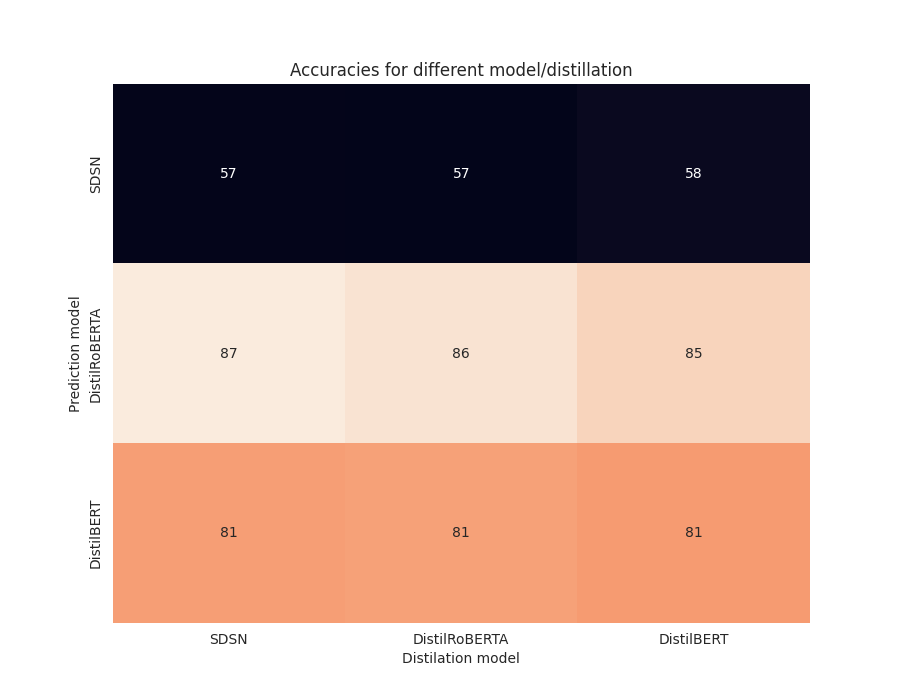

In [62]:
# Plot
_, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(cross_results_, annot=True, cbar=False,
            xticklabels=['SDSN', 'DistilRoBERTA', 'DistilBERT'], yticklabels=['SDSN', 'DistilRoBERTA', 'DistilBERT'])
ax.set(title='Accuracies for different model/distillation',
       xlabel='Distilation model', ylabel='Prediction model');